# Import Libraries

In [1]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np


# Load Saved model

In [2]:
# load the model
new_model = keras.models.load_model('cnn_lstm_original_model.keras')

# Data Preprocessing & Analysis

In [3]:
# For data preprocessing and analysis part

from sklearn.model_selection import train_test_split


data2 = pd.read_csv('../../Datasets/MSFT.csv') 

data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)


numeric_columns = data2.select_dtypes(include=['float64', 'int64']).columns
data2[numeric_columns] = data2[numeric_columns].fillna(data2[numeric_columns].mean())
data2.head()

df2 = data2.drop('Date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

         Open    High       Low   Close    Volume
0      37.350   37.40   37.1000   37.16  30632200
1      37.200   37.22   36.6000   36.91  31134800
2      36.850   36.89   36.1100   36.13  43603700
3      36.325   36.49   36.2100   36.41  35802800
4      36.000   36.14   35.5800   35.76  59971700
...       ...     ...       ...     ...       ...
2532  404.320  407.01  402.5294  404.87  21021155
2533  404.370  406.17  402.4300  403.93  17803271
2534  406.060  409.98  404.3300  409.72  24510236
2535  412.260  413.05  406.4501  408.59  33477610
2536  406.960  415.32  397.2100  397.58  47871097

[2537 rows x 5 columns]
1948
487


In [4]:
new_model.evaluate(test_X, test_Y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2563 - mae: 0.3866 - mse: 0.2558


[0.30312639474868774, 0.3026660978794098, 0.4085386395454407]

In [5]:
# Make predictions
predicted  = new_model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


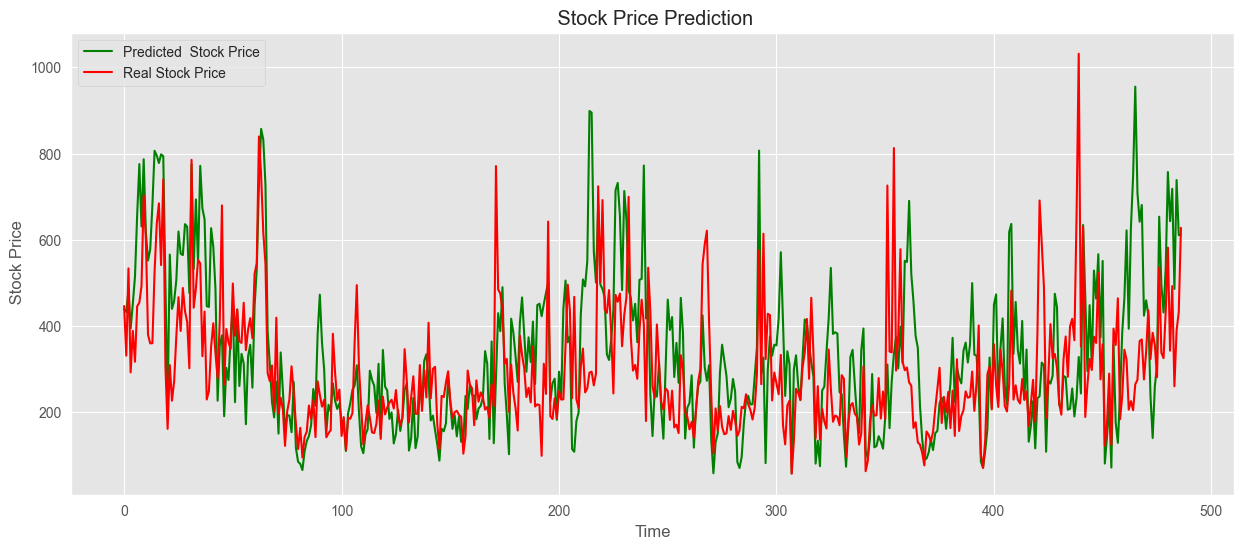

In [6]:
# plot predictions
plt.figure(figsize=(15,6))
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = new_model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.004420
R2 Score: 0.004420
Max Error: 1031.649921


# Performance evaluation

In [8]:
# Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score


# Calculate performance metrics
mse = mean_squared_error(test_label, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_label, predicted)
mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
r2 = r2_score(test_label, predicted)
# r2 = r2_score(actual_prices, predictions)

# Print performance metrics
print("\nPerformance Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R2 Score: {r2:.3f}")


Performance Metrics:
Mean Squared Error (MSE): 24444.21779928578
Root Mean Squared Error (RMSE): 156.34646717878144
Mean Absolute Error (MAE): 115.19766377841727
Mean Absolute Percentage Error (MAPE): 41.05%
R2 Score: -0.188


In [9]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV 
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    mse = round(mse, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

In [10]:
# Save metrics to CSV
save_metrics(test_label, predicted, "CNN-LSTM-Baseline", "MSFT")  


Metrics for CNN-LSTM-Baseline on MSFT:
Mean Squared Error (MSE): 24444.2178
Root Mean Squared Error (RMSE): 156.3465
Mean Absolute Error (MAE): 115.1977
Mean Absolute Percentage Error (MAPE): 41.0460%
R² Score: -0.1876
